# Modelling, Simulation and Optimisation

## TABA

Student ID: x22240217, using 2170(seed value) for this study

### Generating Input Data

In [1]:
N_JOBS = 50
N_MACHINES = 4

In [2]:
import random

def generateData(seed=0):
    PROC = [ [ 0 for m in range(N_MACHINES) ] for j in range(N_JOBS) ]
    random.seed(seed)
    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            PROC[j][m] = random.randint(1,9)
    return PROC

In [3]:
PROC = generateData(2170)

In [4]:
PROC

[[7, 5, 2, 8],
 [2, 5, 1, 5],
 [1, 9, 1, 9],
 [9, 7, 4, 5],
 [6, 9, 2, 2],
 [3, 1, 9, 3],
 [7, 4, 9, 9],
 [6, 5, 5, 3],
 [4, 3, 9, 1],
 [2, 4, 2, 3],
 [1, 9, 6, 3],
 [8, 9, 1, 7],
 [3, 7, 9, 8],
 [8, 5, 3, 9],
 [5, 3, 7, 6],
 [3, 7, 8, 5],
 [3, 6, 1, 9],
 [4, 2, 7, 3],
 [1, 5, 1, 1],
 [6, 7, 8, 2],
 [5, 4, 5, 3],
 [6, 3, 7, 8],
 [4, 2, 5, 4],
 [5, 5, 3, 1],
 [6, 4, 6, 1],
 [8, 1, 9, 2],
 [3, 1, 9, 7],
 [4, 4, 8, 1],
 [9, 1, 4, 1],
 [5, 9, 5, 6],
 [3, 6, 7, 5],
 [6, 6, 2, 2],
 [3, 6, 3, 3],
 [1, 8, 9, 3],
 [9, 5, 6, 9],
 [1, 2, 3, 5],
 [2, 8, 6, 9],
 [1, 8, 4, 9],
 [8, 2, 3, 5],
 [4, 8, 4, 2],
 [8, 4, 5, 1],
 [8, 7, 9, 9],
 [5, 2, 5, 3],
 [3, 1, 3, 6],
 [7, 4, 5, 2],
 [7, 1, 6, 1],
 [3, 3, 7, 8],
 [3, 5, 9, 1],
 [3, 7, 9, 2],
 [2, 6, 2, 2]]

### Integer Programming Solution

Given Code

In [5]:
import pulp

In [6]:
def val(x):
    return int(pulp.value(x))

In [7]:
prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)

`J[j]` defines the sequencing of jobs 'j' and is just a permutation of the job number:

In [8]:
JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)),
                           lowBound=0, upBound=1, cat='Integer')

In [9]:
def job(n):
    for j in range(N_JOBS):
        if val(JJ[n][j])==1:
            return j

In [10]:
def jobSequence():
    acc = []
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
    return acc

In [11]:
def proc(job, machine):
    global PROC
    return pulp.lpSum( [ PROC[j][machine] * JJ[j][job] for j in range(N_JOBS) ] ) 

`WAIT[j][m]` describes the wait time of job `j` before machine `m`

In [12]:
Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

`IDLE[j][m]` describes the idle time of machine `m` before processing job `j` 

In [13]:
Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)),
                             lowBound=0, cat='Integer')

`START[j][m]` describes the start time of machine `m` processing job `j`

In [14]:
Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

`STOP[j][m]` describes the stop time of machine `m` after processing job `j`

In [15]:
Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

In [16]:
prob += Stop[N_JOBS-1][N_MACHINES-1]

In [17]:
for j in range(N_JOBS):
    prob += pulp.lpSum( [ JJ[j][jj] for jj in range(N_JOBS) ] ) == 1
    prob += pulp.lpSum( [ JJ[jj][j] for jj in range(N_JOBS) ] ) == 1

In [18]:
for m in range(N_MACHINES):
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

In [19]:
for m in range(N_MACHINES):
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

In [20]:
for j in range(N_JOBS):
    for m in range(N_MACHINES):
        prob += Start[j][m] + proc(j,m) == Stop[j][m]

In [21]:
solvers = pulp.listSolvers(onlyAvailable=True) 
solver = pulp.getSolver(solvers[0], msg=0)
prob.solve(solver)

1

In [22]:
def schedule():
    row = ""
    row += '|---------|'
    for m in range(N_MACHINES):
        row += f"------------|" \
                f"------------|"
    row += '\n'
    row += '|         |'
    for m in range(N_MACHINES):
        row += f"            |" \
                f" Machine: {m:1d} |"
    row += '\n'
    for j in range(N_JOBS):
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                   f"------------|"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Idle: {val(Idle[j][m]):4d} |"
        row += '\n'
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                   f"------------|"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Start:{val(Start[j][m]):4d} |"  
        row += '\n' 
        row += f'| Job: {job(j):2d} |'
        for m in range(N_MACHINES):
            row += f" Wait: {val(Wait[j][m]):4d} | " \
                   f"Proc: {val(proc(j,m)):4d} |"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Stop: {val(Stop[j][m]):4d} |"  
        row += '\n' 
    row += '|---------|'
    for m in range(N_MACHINES):
        row += f"------------|" \
                f"------------|"
    row += '\n'
    return row

The processing times per job and machine:

In [23]:
PROC

[[7, 5, 2, 8],
 [2, 5, 1, 5],
 [1, 9, 1, 9],
 [9, 7, 4, 5],
 [6, 9, 2, 2],
 [3, 1, 9, 3],
 [7, 4, 9, 9],
 [6, 5, 5, 3],
 [4, 3, 9, 1],
 [2, 4, 2, 3],
 [1, 9, 6, 3],
 [8, 9, 1, 7],
 [3, 7, 9, 8],
 [8, 5, 3, 9],
 [5, 3, 7, 6],
 [3, 7, 8, 5],
 [3, 6, 1, 9],
 [4, 2, 7, 3],
 [1, 5, 1, 1],
 [6, 7, 8, 2],
 [5, 4, 5, 3],
 [6, 3, 7, 8],
 [4, 2, 5, 4],
 [5, 5, 3, 1],
 [6, 4, 6, 1],
 [8, 1, 9, 2],
 [3, 1, 9, 7],
 [4, 4, 8, 1],
 [9, 1, 4, 1],
 [5, 9, 5, 6],
 [3, 6, 7, 5],
 [6, 6, 2, 2],
 [3, 6, 3, 3],
 [1, 8, 9, 3],
 [9, 5, 6, 9],
 [1, 2, 3, 5],
 [2, 8, 6, 9],
 [1, 8, 4, 9],
 [8, 2, 3, 5],
 [4, 8, 4, 2],
 [8, 4, 5, 1],
 [8, 7, 9, 9],
 [5, 2, 5, 3],
 [3, 1, 3, 6],
 [7, 4, 5, 2],
 [7, 1, 6, 1],
 [3, 3, 7, 8],
 [3, 5, 9, 1],
 [3, 7, 9, 2],
 [2, 6, 2, 2]]

The optimal job schedule:

In [24]:
print(jobSequence())

[43, 5, 17, 45, 28, 1, 4, 29, 18, 3, 19, 39, 33, 35, 22, 37, 10, 12, 32, 48, 25, 36, 11, 26, 40, 16, 6, 23, 34, 42, 21, 30, 13, 15, 46, 0, 20, 14, 31, 27, 49, 47, 8, 2, 38, 24, 9, 44, 41, 7]


The processing time of the optimal job schedule:

In [25]:
int(pulp.value(prob.objective))

267

The optimal job schedule in detail:

In [26]:
print(schedule())

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    1 |            | Idle:    3 |            | Idle:    6 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   1 |            | Start:   3 |            | Start:   6 |
| Job: 43 | Wait:    0 | Proc:    1 | Wait:    0 | Proc:    2 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    5 |
|         |            | Stop:    1 |            | Stop:    3 |            | Stop:    6 |            | Stop:   11 |
|---------|------------|------------|------------|------------|---------

### Genetic Algorithm

In [27]:
# Below function is essential for evaluating the fitness of candidate schedules for determining the optimal Schedule
def calculate_makespan(schedule, proc):
    end_times = np.zeros((N_JOBS, N_MACHINES))
    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            if idx == 0 and m == 0:
                end_times[job][m] = proc[job][m]
            elif idx == 0:
                end_times[job][m] = end_times[job][m-1] + proc[job][m]
            elif m == 0:
                end_times[job][m] = end_times[schedule[idx-1]][m] + proc[job][m]
            else:
                end_times[job][m] = max(end_times[job][m-1], end_times[schedule[idx-1]][m]) + proc[job][m]
    return end_times[schedule[-1]][-1]

# Calculate the fitness value of a given schedule based on the reciprocal of its makespan
def fitness(schedule, proc):
    return 1 / calculate_makespan(schedule, PROC)

# Initialize a population of schedules by randomly shuffling job sequences
def initialize_population(size):
    return [random.sample(range(N_JOBS), N_JOBS) for _ in range(size)]

# Select parents for crossover using tournament selection with a specified tournament size
def select_parents(population, proc):
    return random.sample(population, 2)

# Add two children to the population and keep the population size constant by selecting the top individuals based on fitness
def addChildren(population, X, Y):
    n = len(population)
    population = add(population, X)
    population = add(population, Y)
    
    if len(population) > n:
        return sorted(population, key=lambda p: fitness(p), reverse=True)[0:n]
    else:
        return population

# Perform crossover between two parents to generate a child
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None]*size
    child[start:end] = parent1[start:end]
    fill = [item for item in parent2 if item not in child[start:end]]
    child = fill[:start] + child[start:end] + fill[start:]
    return child

# Mutate the given schedule with 0.1 mutation rate
def mutate(schedule, mutation_rate=0.1):
    schedule = schedule[:]
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(schedule)), 2)
        schedule[i], schedule[j] = schedule[j], schedule[i]
    return schedule

In [28]:
# Genetic algorithm for job scheduling
import numpy as np
def genetic_algorithm(generations=128, pop_size=128, mutation_rate=0.1, logging=True):
    proc = generateData(seed=2170)
    population = initialize_population(pop_size)

    for generation in range(generations):
        new_population = []
        for _ in range(pop_size // 2):
            parent1, parent2 = select_parents(population, proc)
            child1 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = crossover(parent2, parent1)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])
        
        # Evaluate new population's fitness and sort
        population = sorted(new_population, key=lambda indiv: fitness(indiv, proc), reverse=True)[:pop_size]

        # Evaluate the best schedule in the current population
        best_in_pop = max(population, key=lambda indiv: fitness(indiv, proc))
        best_in_pop_fitness = fitness(best_in_pop, proc)
        best_in_pop_makespan = calculate_makespan(best_in_pop, proc)

        # Logging the progress if enabled
        if logging:
            print(f"Generation {generation + 1}:")
            print("  Best Schedule:", best_in_pop)
            print("  Best Fitness:", best_in_pop_fitness)
            print("  Best Makespan:", best_in_pop_makespan)
            print()

    # Final best schedule and evaluation
    best_schedule = max(population, key=lambda indiv: fitness(indiv, proc))
    best_fitness = fitness(best_schedule, proc)
    best_makespan = calculate_makespan(best_schedule, proc)
    return best_schedule, best_makespan, best_fitness

# Example of calling the genetic algorithm with logging enabled
best_schedule, best_makespan, best_fitness = genetic_algorithm(logging=True)
print("Final Best Schedule:", best_schedule)
print("Final Best Makespan:", best_makespan)
print("Final Best Fitness:", best_fitness)


Generation 1:
  Best Schedule: [47, 16, 42, 15, 35, 23, 17, 6, 2, 27, 0, 44, 48, 21, 12, 39, 37, 34, 9, 8, 18, 30, 26, 45, 25, 10, 7, 3, 11, 31, 19, 49, 43, 38, 40, 5, 20, 36, 28, 1, 33, 29, 46, 4, 14, 13, 41, 24, 32, 22]
  Best Fitness: 0.0035971223021582736
  Best Makespan: 278.0

Generation 2:
  Best Schedule: [12, 27, 25, 21, 9, 15, 44, 48, 3, 30, 39, 11, 16, 43, 5, 14, 41, 1, 42, 46, 37, 38, 45, 10, 40, 17, 8, 49, 36, 29, 32, 35, 4, 24, 19, 18, 13, 26, 2, 0, 20, 6, 31, 22, 28, 23, 47, 33, 34, 7]
  Best Fitness: 0.0035714285714285713
  Best Makespan: 280.0

Generation 3:
  Best Schedule: [18, 26, 35, 1, 17, 33, 3, 46, 41, 25, 48, 42, 21, 9, 12, 30, 47, 49, 34, 38, 5, 44, 43, 39, 20, 29, 28, 4, 2, 19, 31, 32, 6, 16, 22, 37, 24, 10, 11, 27, 36, 40, 15, 23, 13, 14, 8, 0, 7, 45]
  Best Fitness: 0.003676470588235294
  Best Makespan: 272.0

Generation 4:
  Best Schedule: [12, 27, 25, 21, 9, 15, 30, 39, 16, 43, 5, 41, 1, 37, 45, 10, 40, 8, 29, 32, 4, 24, 19, 18, 13, 26, 6, 31, 35, 22, 14,

Generation 39:
  Best Schedule: [30, 15, 4, 19, 27, 40, 42, 23, 38, 33, 6, 41, 18, 8, 39, 16, 22, 1, 36, 26, 24, 0, 5, 44, 3, 35, 37, 2, 29, 31, 9, 45, 17, 10, 20, 32, 13, 21, 7, 34, 43, 46, 25, 12, 49, 47, 14, 28, 11, 48]
  Best Fitness: 0.0035714285714285713
  Best Makespan: 280.0

Generation 40:
  Best Schedule: [27, 15, 12, 44, 41, 1, 43, 31, 5, 17, 8, 25, 29, 7, 13, 39, 20, 24, 0, 34, 4, 46, 14, 3, 42, 6, 35, 21, 10, 18, 30, 38, 36, 26, 33, 16, 23, 2, 11, 22, 40, 49, 45, 28, 32, 47, 9, 48, 37, 19]
  Best Fitness: 0.0035714285714285713
  Best Makespan: 280.0

Generation 41:
  Best Schedule: [33, 27, 3, 26, 39, 21, 47, 22, 40, 42, 44, 32, 1, 49, 37, 14, 5, 11, 35, 43, 34, 4, 41, 16, 20, 48, 38, 19, 46, 6, 15, 30, 23, 7, 28, 36, 12, 24, 25, 2, 31, 45, 13, 10, 8, 0, 17, 18, 9, 29]
  Best Fitness: 0.0035714285714285713
  Best Makespan: 280.0

Generation 42:
  Best Schedule: [9, 8, 34, 33, 10, 13, 27, 15, 36, 16, 28, 46, 45, 43, 0, 1, 48, 21, 38, 25, 6, 22, 2, 39, 3, 7, 47, 12, 42, 14, 

Generation 78:
  Best Schedule: [8, 33, 17, 37, 26, 5, 34, 14, 43, 32, 16, 21, 29, 30, 10, 28, 38, 22, 0, 4, 31, 40, 9, 46, 3, 27, 35, 6, 36, 18, 13, 2, 25, 41, 24, 15, 44, 45, 7, 11, 42, 1, 23, 12, 39, 19, 47, 48, 20, 49]
  Best Fitness: 0.003663003663003663
  Best Makespan: 273.0

Generation 79:
  Best Schedule: [12, 6, 30, 31, 13, 16, 5, 22, 14, 1, 32, 19, 49, 0, 45, 36, 46, 37, 44, 34, 20, 7, 10, 21, 28, 38, 26, 9, 29, 47, 2, 27, 18, 35, 40, 17, 43, 48, 41, 25, 4, 33, 42, 8, 39, 3, 15, 24, 11, 23]
  Best Fitness: 0.0035971223021582736
  Best Makespan: 278.0

Generation 80:
  Best Schedule: [2, 8, 24, 17, 35, 34, 38, 26, 14, 21, 29, 1, 9, 37, 25, 5, 32, 12, 19, 49, 46, 7, 0, 4, 31, 15, 6, 43, 20, 3, 33, 48, 36, 40, 44, 42, 11, 22, 23, 18, 13, 41, 27, 10, 16, 28, 45, 39, 30, 47]
  Best Fitness: 0.0035971223021582736
  Best Makespan: 278.0

Generation 81:
  Best Schedule: [49, 15, 9, 35, 27, 6, 32, 45, 0, 38, 12, 42, 5, 40, 20, 16, 37, 28, 30, 3, 33, 48, 24, 26, 23, 1, 17, 21, 2, 13, 

Generation 110:
  Best Schedule: [22, 5, 15, 49, 6, 13, 12, 17, 4, 30, 25, 32, 34, 35, 19, 21, 16, 1, 41, 36, 31, 26, 20, 18, 39, 48, 0, 38, 10, 24, 46, 23, 40, 29, 3, 9, 47, 43, 14, 28, 33, 44, 2, 37, 8, 45, 42, 11, 27, 7]
  Best Fitness: 0.003663003663003663
  Best Makespan: 273.0

Generation 111:
  Best Schedule: [5, 15, 49, 13, 12, 17, 4, 30, 45, 22, 6, 46, 3, 25, 32, 34, 35, 19, 21, 16, 1, 41, 36, 31, 26, 20, 18, 39, 48, 0, 38, 10, 24, 23, 40, 29, 9, 47, 43, 14, 28, 33, 44, 2, 37, 8, 42, 11, 27, 7]
  Best Fitness: 0.0036231884057971015
  Best Makespan: 276.0

Generation 112:
  Best Schedule: [21, 27, 32, 36, 26, 45, 9, 6, 48, 47, 18, 7, 31, 44, 35, 13, 30, 16, 11, 25, 15, 17, 22, 49, 37, 39, 8, 29, 3, 42, 43, 33, 0, 14, 38, 24, 34, 4, 46, 5, 28, 1, 2, 20, 10, 41, 23, 12, 19, 40]
  Best Fitness: 0.0036496350364963502
  Best Makespan: 274.0

Generation 113:
  Best Schedule: [5, 19, 24, 33, 21, 25, 31, 14, 35, 12, 4, 27, 41, 6, 17, 49, 22, 0, 18, 39, 28, 9, 37, 13, 34, 15, 26, 45, 46

In [29]:
# Calculate makespan and generate timelines for job start and end times
import numpy as np

def calculate_makespan_and_timeline(schedule, proc):
    end_times = np.zeros((N_JOBS, N_MACHINES))
    start_times = np.zeros((N_JOBS, N_MACHINES))
    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            if idx == 0 and m == 0:
                start_times[job][m] = 0
                end_times[job][m] = proc[job][m]
            elif idx == 0:
                start_times[job][m] = end_times[job][m-1]
                end_times[job][m] = start_times[job][m] + proc[job][m]
            elif m == 0:
                start_times[job][m] = end_times[schedule[idx-1]][m]
                end_times[job][m] = start_times[job][m] + proc[job][m]
            else:
                start_times[job][m] = max(end_times[job][m-1], end_times[schedule[idx-1]][m])
                end_times[job][m] = start_times[job][m] + proc[job][m]
    return end_times[schedule[-1]][-1], start_times, end_times

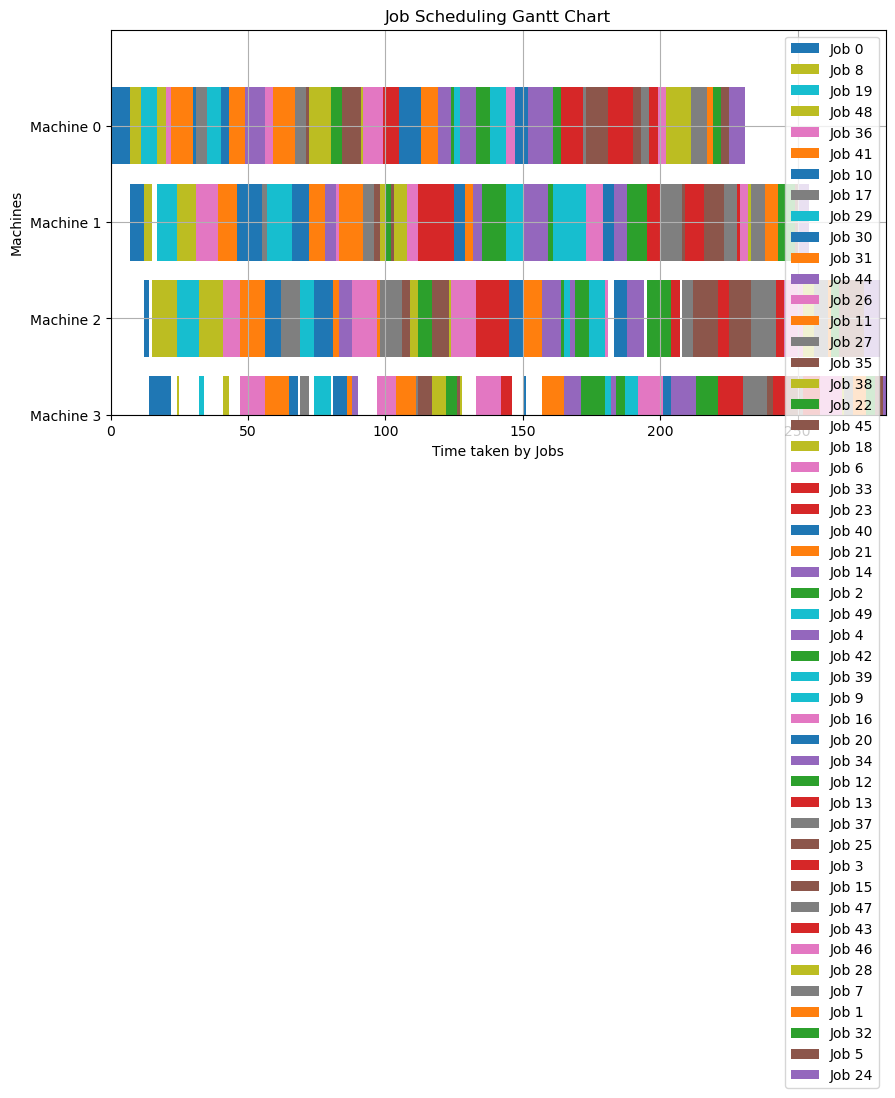

In [30]:
# To plot Gantt chart for the observations
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_gantt_chart(schedule, start_times, end_times):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = list(mcolors.TABLEAU_COLORS.keys())
    # Create machine labels in reverse order
    machines = ['Machine {}'.format(N_MACHINES - 1 - i) for i in range(N_MACHINES)]

    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            start = start_times[job][m]
            duration = end_times[job][m] - start
            # Plot in reverse order by subtracting m from N_MACHINES - 1
            machine_position = N_MACHINES - 1 - m
            ax.broken_barh([(start, duration)], (machine_position - 0.4, 0.8), facecolors=colors[job % len(colors)], label=f'Job {job}' if m == 0 else "")

    ax.set_ylim(0, N_MACHINES)
    ax.set_xlim(0, np.max(end_times))
    ax.set_xlabel('Time taken by Jobs')
    ax.set_ylabel('Machines')
    ax.set_yticks(range(N_MACHINES))
    ax.set_yticklabels(machines)
    ax.set_title('Job Scheduling Gantt Chart')
    # Ensure that legends do not repeat
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()

# Calculate makespan and generate timelines for job start and end times
best_makespan, start_times, end_times = calculate_makespan_and_timeline(best_schedule, PROC)
plot_gantt_chart(best_schedule, start_times, end_times)


### Ant Colony Optmization

In [31]:
import numpy as np
import random

# ACO specific parameters
num_ants = N_JOBS  # One ant per job
num_iterations = 100
evaporation_rate = 0.5
pheromone_deposit = 1.0
initial_pheromone = 1.0 / N_JOBS

# Generate processing times
processing_times = generateData(2170)

# Initialize pheromone levels
pheromones = np.ones((N_JOBS, N_JOBS)) * initial_pheromone

In [32]:
# ACO Algorithm
def calculate_makespan_and_timeline(schedule):
    job_start_times = np.zeros((N_MACHINES, N_JOBS))
    job_end_times = np.zeros((N_MACHINES, N_JOBS))
    for idx, job in enumerate(schedule):
        for machine in range(N_MACHINES):
            if machine == 0:
                job_start_times[machine][idx] = job_end_times[machine][idx-1] if idx > 0 else 0
            else:
                job_start_times[machine][idx] = max(job_end_times[machine-1][idx], job_end_times[machine][idx-1])
            job_end_times[machine][idx] = job_start_times[machine][idx] + processing_times[job][machine]
    return job_end_times[-1][-1], job_start_times, job_end_times

def select_next_job(current_job, taboo_list):
    probabilities = pheromones[current_job] * np.array([1 if i not in taboo_list else 0 for i in range(N_JOBS)])
    if probabilities.sum() == 0:
        return random.choice([i for i in range(N_JOBS) if i not in taboo_list])
    probabilities /= probabilities.sum()
    return np.random.choice(N_JOBS, p=probabilities)

# Ant Colony Optimization
best_schedule = None
best_makespan = float('inf')
best_start_times = None
best_end_times = None

for iteration in range(num_iterations):
    for ant in range(num_ants):
        schedule = []
        current_job = random.randint(0, N_JOBS - 1)
        schedule.append(current_job)
        taboo_list = set(schedule)

        while len(taboo_list) < N_JOBS:
            next_job = select_next_job(current_job, taboo_list)
            schedule.append(next_job)
            taboo_list.add(next_job)
            current_job = next_job

        makespan, start_times, end_times = calculate_makespan_and_timeline(schedule)
        if makespan < best_makespan:
            best_makespan = makespan
            best_schedule = schedule
            best_start_times = start_times
            best_end_times = end_times

    # Update pheromones
    pheromones *= (1 - evaporation_rate)  # Evaporate pheromones
    for idx in range(N_JOBS-1):
        pheromones[best_schedule[idx]][best_schedule[idx+1]] += pheromone_deposit

    print(f"Iteration {iteration}: Best Makespan = {best_makespan}, Job Sequence = {best_schedule}")

# Output the best solution found
print("Best job sequence:", best_schedule)
print("Best makespan:", best_makespan)



Iteration 0: Best Makespan = 282.0, Job Sequence = [2, 44, 20, 7, 19, 48, 47, 24, 6, 0, 46, 39, 22, 12, 17, 4, 9, 13, 18, 40, 23, 5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 11, 21, 35, 28, 1, 45, 29, 43, 31, 25, 10, 32, 27, 33]
Iteration 1: Best Makespan = 276.0, Job Sequence = [46, 39, 20, 7, 19, 48, 12, 17, 4, 9, 13, 18, 40, 23, 5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47]
Iteration 2: Best Makespan = 276.0, Job Sequence = [46, 39, 20, 7, 19, 48, 12, 17, 4, 9, 13, 18, 40, 23, 5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47]
Iteration 3: Best Makespan = 276.0, Job Sequence = [46, 39, 20, 7, 19, 48, 12, 17, 4, 9, 13, 18, 40, 23, 5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47]
Iteration 4: Best Makespan = 276

Iteration 38: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 39: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 40: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 41: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 42: Best Makespan 

Iteration 73: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 74: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 75: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 76: Best Makespan = 275.0, Job Sequence = [5, 15, 16, 42, 8, 14, 38, 26, 34, 36, 37, 3, 30, 49, 41, 6, 0, 27, 33, 22, 2, 44, 24, 1, 45, 29, 43, 31, 25, 11, 21, 35, 28, 32, 10, 47, 12, 17, 4, 9, 13, 18, 40, 23, 46, 39, 20, 7, 19, 48]
Iteration 77: Best Makespan 

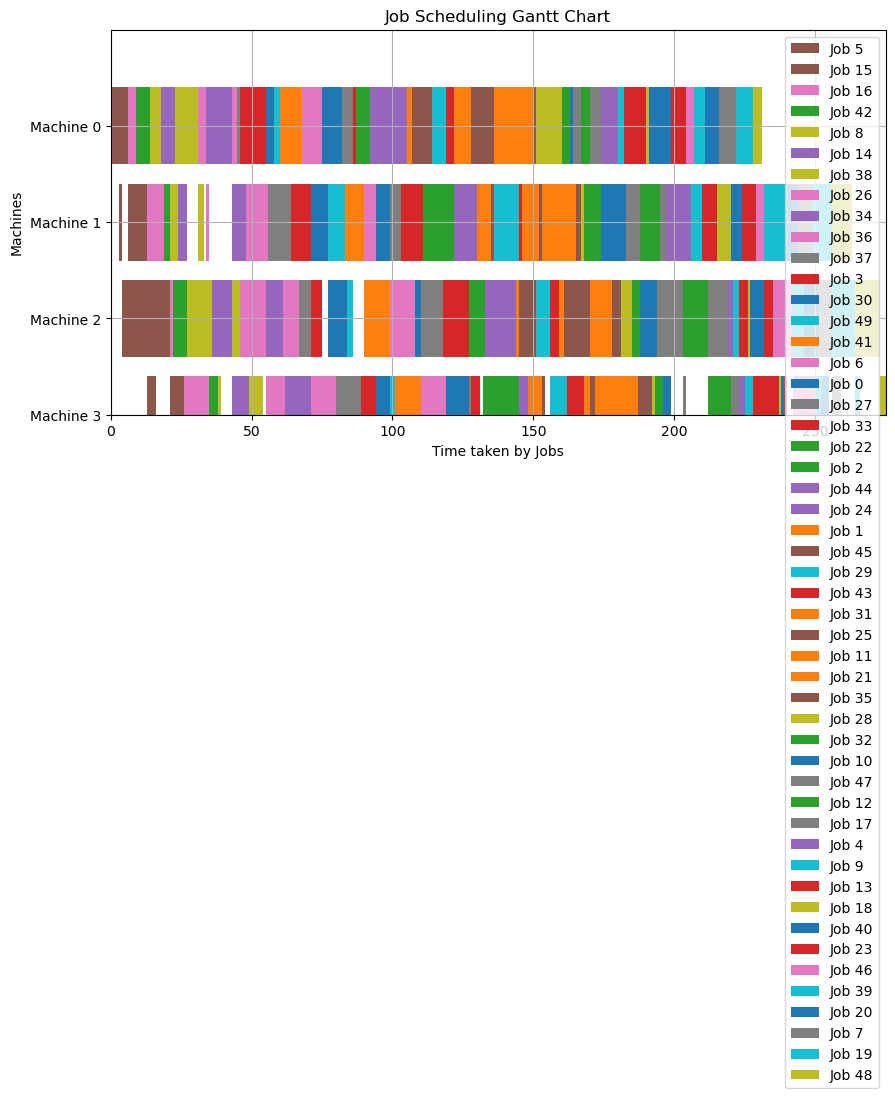

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_gantt_chart(schedule, start_times, end_times):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = list(mcolors.TABLEAU_COLORS.keys())[:N_JOBS]
    machines = ['Machine {}'.format(N_MACHINES - 1 - i) for i in range(N_MACHINES)]

    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            start = start_times[m][idx]
            duration = end_times[m][idx] - start
            machine_position = N_MACHINES - 1 - m
            ax.broken_barh([(start, duration)], (machine_position - 0.4, 0.8), facecolors=colors[job % len(colors)], label=f'Job {job}' if m == 0 else "")

    ax.set_ylim(0, N_MACHINES)
    ax.set_xlim(0, np.max(end_times))
    ax.set_xlabel('Time taken by Jobs')
    ax.set_ylabel('Machines')
    ax.set_yticks(range(N_MACHINES))
    ax.set_yticklabels(machines)
    ax.set_title('Job Scheduling Gantt Chart')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()

# Plot Gantt chart
plot_gantt_chart(best_schedule, best_start_times, best_end_times)


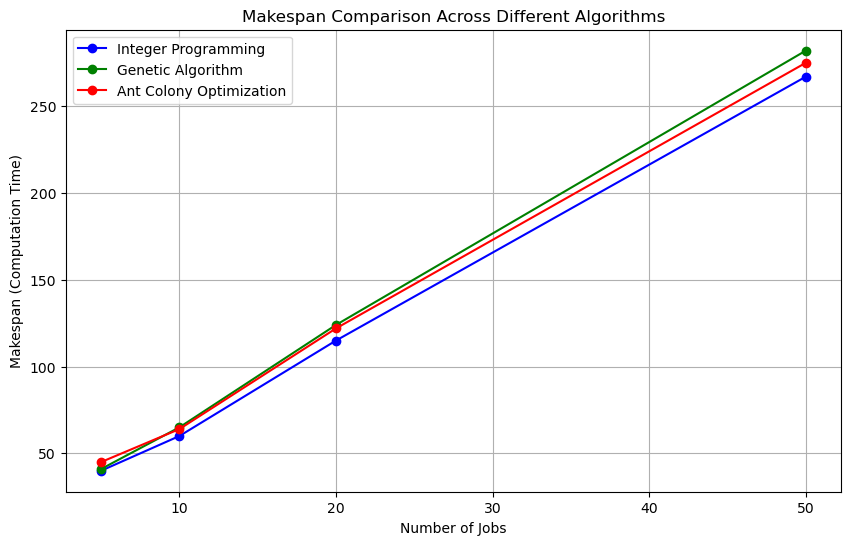

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data setup for plotting
num_jobs = np.array([5, 10, 20, 50])  # Number of jobs
computation_times_ip = np.array([40, 60, 115, 267])  # Makespans for Integer Programming
computation_times_ga = np.array([41.0, 65.0, 124.0, 282.0])  # Makespans for Genetic Algorithm
computation_times_aco = np.array([45.0, 64.0, 122.0, 275.0])  # Makespans for Ant Colony Optimization

# Ensure all data is in proper numpy array format for consistency
plt.figure(figsize=(10, 6))
plt.plot(num_jobs, computation_times_ip, 'o-', color='blue', label='Integer Programming')
plt.plot(num_jobs, computation_times_ga, 'o-', color='green', label='Genetic Algorithm')
plt.plot(num_jobs, computation_times_aco, 'o-', color='red', label='Ant Colony Optimization')

plt.xlabel('Number of Jobs')
plt.ylabel('Makespan (Computation Time)')
plt.title('Makespan Comparison Across Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()
